<h1 align=center><font size = 5>Bitcoin OTC trust weighted signed network
</font></h1>

<h0 align=left><font size = 3>#bitcoin-otc is an over-the-counter marketplace for trading with bitcoin. The marketplace is located in #bitcoin-otc channel on the freenode IRC network. </font></h0>

https://www.bitcoin-otc.com/

<h0 align=left><font size = 3>To complement the OTC marketplace, they offer a web of trust service. Due to the p2p nature of OTC transactions, people are exposed to counterparty risk. To mitigate this risk, they need to have access to their counterparty's reputation and trade history. This is precisely the kind of information that the OTC web of trust provides. </font></h0>

## Data Set information 

<h0 align=left><font size = 3>This is who-trusts-whom network of people who trade using Bitcoin on a platform called Bitcoin OTC. Since Bitcoin users are anonymous, there is a need to maintain a record of users' reputation to prevent transactions with fraudulent and risky users. Members of Bitcoin OTC rate other members in a scale of -10 (total distrust) to +10 (total trust) in steps of 1. This is the first explicit weighted signed directed network available for research. </font></h0>

## Data format 

<h0 align=left><font size = 3>Each line has one rating, sorted by time, with the following format:

SOURCE, TARGET, RATING, TIME</font></h0>


## Necessary libraries 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

## Drawing functions 

In [2]:
def draw_graph (G_sample):
    # draw the network G1
    fig= plt.figure(figsize=(20,15))
    nx.draw_spring(G_sample,node_color = 'g',with_labels=False,node_size=150,edge_color='Gray',alpha=0.7)
    return 

## Data preparations

In [3]:
data = pd.read_csv('data.csv')

In [4]:
data.head()

,Source,Target,Score,Time
0,6,2,4,1.289242e+09
1,6,5,2,1.289242e+09
2,1,15,1,1.289243e+09
3,4,3,7,1.289245e+09
4,13,16,8,1.289254e+09


<h0 align=left><font size = 3>For instance I won't use the Time information as I will consider all scoring was on the same time for eveyone </font></h0>

In [5]:
data.columns

Index(['Source', 'Target', 'Score', 'Time'], dtype='object')

In [6]:
data.drop('Time', axis = 1,inplace = True)

In [7]:
print("The data size is : {} ".format(data.shape))

The data size is : (35592, 3) 


## Graph construction 

In [8]:
import networkx as nx

In [9]:
data_array=np.array(data)

In [10]:
G=nx.DiGraph()

In [11]:
data_array.shape[0]

35592

In [12]:
for i in range (data_array.shape[0]): 
    G.add_edge(data_array[i][0],data_array[i][1],score=data_array[i][2])

In [13]:
G.is_directed()

True

In [14]:
G.number_of_nodes()

5881

In [15]:
G.number_of_edges()

35592

## ScoingRank Algorithm 

In [16]:
def top_percent_page_rank(G , per = 0.02):
    page_rank = nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight=None, dangling=None)

    lis=[]
    dic = dict(page_rank)

    #Top per of the data 
    n= int(per * G.number_of_nodes())

    for i in range (0,n) :
        maximum = 0 
        node = 0
        for elt in dic : 
            if dic[elt]> maximum  : 
                maximum = dic[elt]
                node = elt
            
        del dic[node]
        lis.append(node)
    lis_degree=lis
    #print(lis_degree)
    return lis_degree

In [17]:
def top_percent_hub (G , per = 0.02):
    hub,auth =nx.hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True)
    
    lis=[]
    dic = dict(hub)

    #Top per of the data 
    n= int(per * G.number_of_nodes())

    for i in range (0,n) :
        maximum = 0 
        node = 0
        for elt in dic : 
            if dic[elt]> maximum  : 
                maximum = dic[elt]
                node = elt
            
        del dic[node]
        lis.append(node)
    lis_degree=lis
    #print(lis_degree)
    return lis_degree

In [18]:
def scoringRank (G,alpha=0.85,betta=3,gamma=0.8,num_iter=3,sigma=0,zetta=5) : 
    # alpha , the percentage taken from the received score from non popular nodes
    # betta , threshold that defines the minimum of in_degree to calculate the trust 
    # gamma, the percentage of nodes that are considered as specially popular 
    # num_iter, number of iterations to claculate the reusrive part of the the second step of the algo
    
    
    # initialisation the trust score to 0 
    for node in G.nodes():
        G.nodes[node]['trust']=0

    # making the trust score the sum of all the scores 
    for edge in G.edges(data=True) : 
        G.nodes[edge[1]]['trust']=G.nodes[edge[1]]['trust']+edge[2]['score']

    # considering the mean not the sum 
    for node in G.nodes():
        if (G.in_degree(node) >= betta):
            G.nodes[node]['trust']= G.nodes[node]['trust'] / (G.in_degree(node))
        else :
            G.nodes[node]['trust']= 0

    
    
    ###  Step 2 : Considering the initial score of the person who scored
    i=1
    while i<=num_iter :
        # initialisation the trust_2 score to 0 
        dic = {}
        for node in G.nodes():
            dic[node]=0
        # calculating trust_2 (considering trust_1 and the received scores )
        for edge in G.edges(data=True) : 
            if G.nodes[edge[0]]['trust'] > 0 : 
                if G.in_degree(edge[1]) >= betta :  
                    dic[edge[1]]=dic[edge[1]]+(edge[2]['score']/(G.in_degree(edge[1])))
        # trust receives trust_2
        for node in G.nodes() : 
            G.nodes[node]['trust']=dic[node]
        i=i+1 

    
    
    ### Step 3 : Giving greater importance to the nodes who are most popular 
    # scaled
    if sigma == 0 :
        list_popular_nodes= top_percent_page_rank(G , per = gamma) 
    elif sigma ==1 : 
        list_popular_nodes= top_percent_hub (G , per = gamma)

    dic = {}
    for node in G.nodes():
        dic[node]=0

    # calculating trust_2 (considering trust_1 and the received scores )
    for edge in G.edges(data=True) : 
        if G.nodes[edge[0]]['trust'] > 0 : 
            if G.in_degree(edge[1]) >= betta :  
                if edge[0] in list_popular_nodes : 
                    dic[edge[1]]=dic[edge[1]]+(edge[2]['score']*(2-alpha)/(G.in_degree(edge[1])))
                else : 
                    dic[edge[1]]=dic[edge[1]]+((edge[2]['score']*alpha)/(G.in_degree(edge[1])))

    # trust receives dic values 
    for node in G.nodes() : 
        G.nodes[node]['trust']=round(dic[node],zetta)
        
    return dict(G.nodes(data=True))

In [19]:
dict(G.nodes(data=True));

<h0 align=left><font size = 3> 
    * alpha    (0.8)  : the percentage taken from the received score from non popular nodes
    * betta    (3)    : threshold that defines the minimum of in_degree to calculate the trust 
    * gamma    (0.3)  : the percentage of nodes that are considered as specially popular 
    * num_iter (3)    : number of iterations to claculate the reusrive part of the the second step of the algo . 
    * sigma    (0/1)  : Using which algorithm to classify the centrality of the node , pageRank = 0 , hub = 1
    * zetta    (0)    : Number of digits after the vigule 
   </font></h0>

In [20]:
G.edges(data=True);

In [21]:
scoringRank_results = scoringRank (G,alpha=0.75,betta=5,gamma=0.7,num_iter=4,sigma=1,zetta=20)

In [22]:
scoringRank_results

{6: {'trust': 1.6193181818181812},
 2: {'trust': 3.567073170731706},
 5: {'trust': 0},
 1: {'trust': 3.6338495575221232},
 15: {'trust': 1.538461538461539},
 4: {'trust': 3.2175925925925943},
 3: {'trust': -0.5952380952380965},
 13: {'trust': 1.7670157068062813},
 16: {'trust': 0},
 10: {'trust': 7.5},
 7: {'trust': 2.673611111111116},
 21: {'trust': 2.5961538461538463},
 20: {'trust': 1.625},
 8: {'trust': 0},
 17: {'trust': 2.894736842105264},
 23: {'trust': 2.5961538461538463},
 25: {'trust': 2.6327433628318584},
 26: {'trust': 1.1363636363636362},
 28: {'trust': 1.7045454545454541},
 29: {'trust': 1.7857142857142856},
 31: {'trust': 0},
 32: {'trust': 1.25},
 34: {'trust': 0},
 35: {'trust': 1.0724299065420557},
 36: {'trust': 1.3636363636363633},
 37: {'trust': 1.25},
 44: {'trust': 0},
 39: {'trust': 3.7500000000000004},
 45: {'trust': 1.7045454545454546},
 19: {'trust': 3.25},
 46: {'trust': 0},
 47: {'trust': 0},
 51: {'trust': 1.4655172413793107},
 52: {'trust': 0},
 53: {'tru

In [23]:
page_rank = nx.pagerank(G, alpha=0.85, personalization=None, max_iter=100, tol=1e-06, nstart=None, weight=None, dangling=None)

In [24]:
in_degree_centrality = nx.in_degree_centrality(G)
out_degree_centrality = nx.out_degree_centrality(G)

In [25]:
hub,auth =nx.hits(G, max_iter=100, tol=1e-08, nstart=None, normalized=True)

In [26]:
mean_in = {}
for node in G.nodes():
    mean_in[node]=0

for edge in G.edges(data=True) :  
    mean_in[edge[1]]=mean_in[edge[1]]+(edge[2]['score']/(G.in_degree(edge[1])))

In [27]:
mean_out = {}
for node in G.nodes():
    mean_out[node]=0

for edge in G.edges(data=True) :  
    mean_out[edge[0]]=mean_out[edge[0]]+(edge[2]['score']/(G.out_degree(edge[0])))

In [28]:
st = []
for edge in G.edges(data=True) : 
    l= [(edge[0],edge[1]),out_degree_centrality[edge[0]],out_degree_centrality[edge[1]],in_degree_centrality[edge[0]],in_degree_centrality[edge[1]],page_rank[edge[0]],page_rank[edge[1]],hub[edge[0]],hub[edge[1]],auth[edge[0]],auth[edge[1]],mean_in[edge[0]],mean_in[edge[1]],mean_out[edge[0]],mean_out[edge[1]],scoringRank_results[edge[0]]['trust'],scoringRank_results[edge[1]]['trust'],edge[2]['score']]
    st.append(l)

### Data frame

In [29]:
df=pd.DataFrame(st)

In [30]:
df.columns=['edge','out_degree_1','out_degree_2','in_degree_1','in_degree_2','page_rank_1','page_rank_2','hub_score_1','hub_score_2','auth_score_1','auth_score_2','mean_in_1','mean_in_2','mean_out_1','mean_out_2','trust_score_1','trust_score_2','score_1->2']

In [31]:
df.drop(['edge'], axis = 1,inplace = True)

In [32]:
df.columns

Index(['out_degree_1', 'out_degree_2', 'in_degree_1', 'in_degree_2',
       'page_rank_1', 'page_rank_2', 'hub_score_1', 'hub_score_2',
       'auth_score_1', 'auth_score_2', 'mean_in_1', 'mean_in_2', 'mean_out_1',
       'mean_out_2', 'trust_score_1', 'trust_score_2', 'score_1->2'],
      dtype='object')

In [33]:
len(df.columns)

17

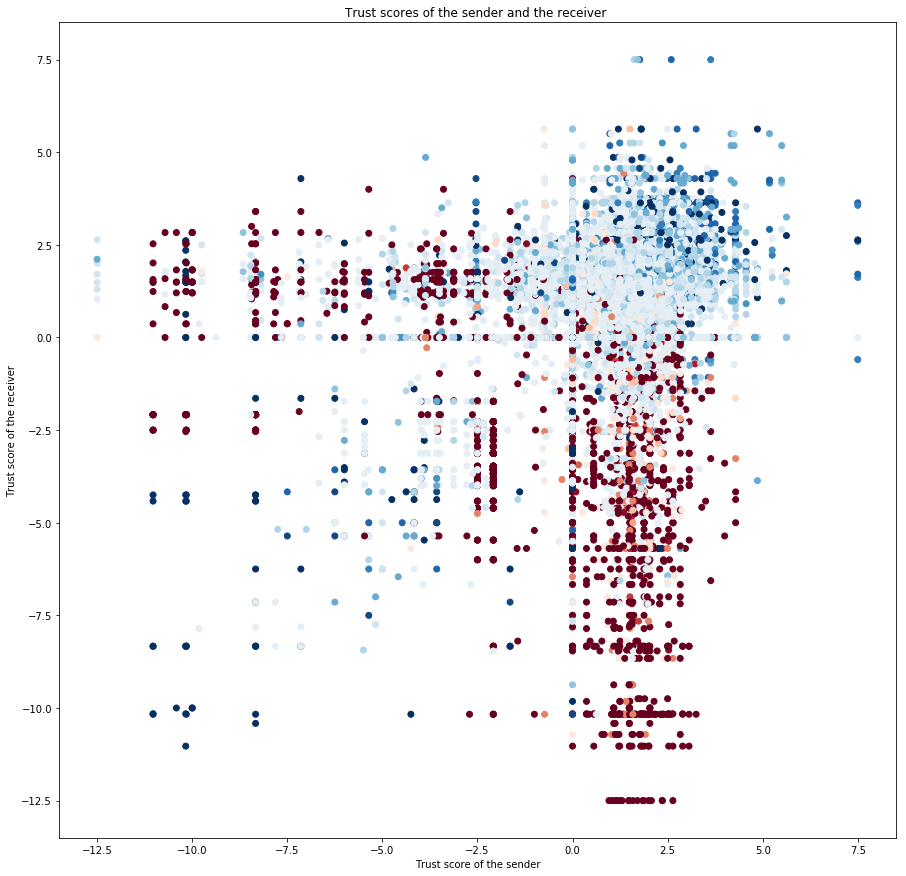

In [34]:
f, ax = plt.subplots(figsize=(15,15))

plt.scatter(df['trust_score_1'],df['trust_score_2'],c=df['score_1->2'],cmap=plt.cm.get_cmap('RdBu'))

plt.title("Trust scores of the sender and the receiver ")

plt.xlabel("Trust score of the sender")
plt.ylabel("Trust score of the receiver")

plt.show()

## Data Treatment

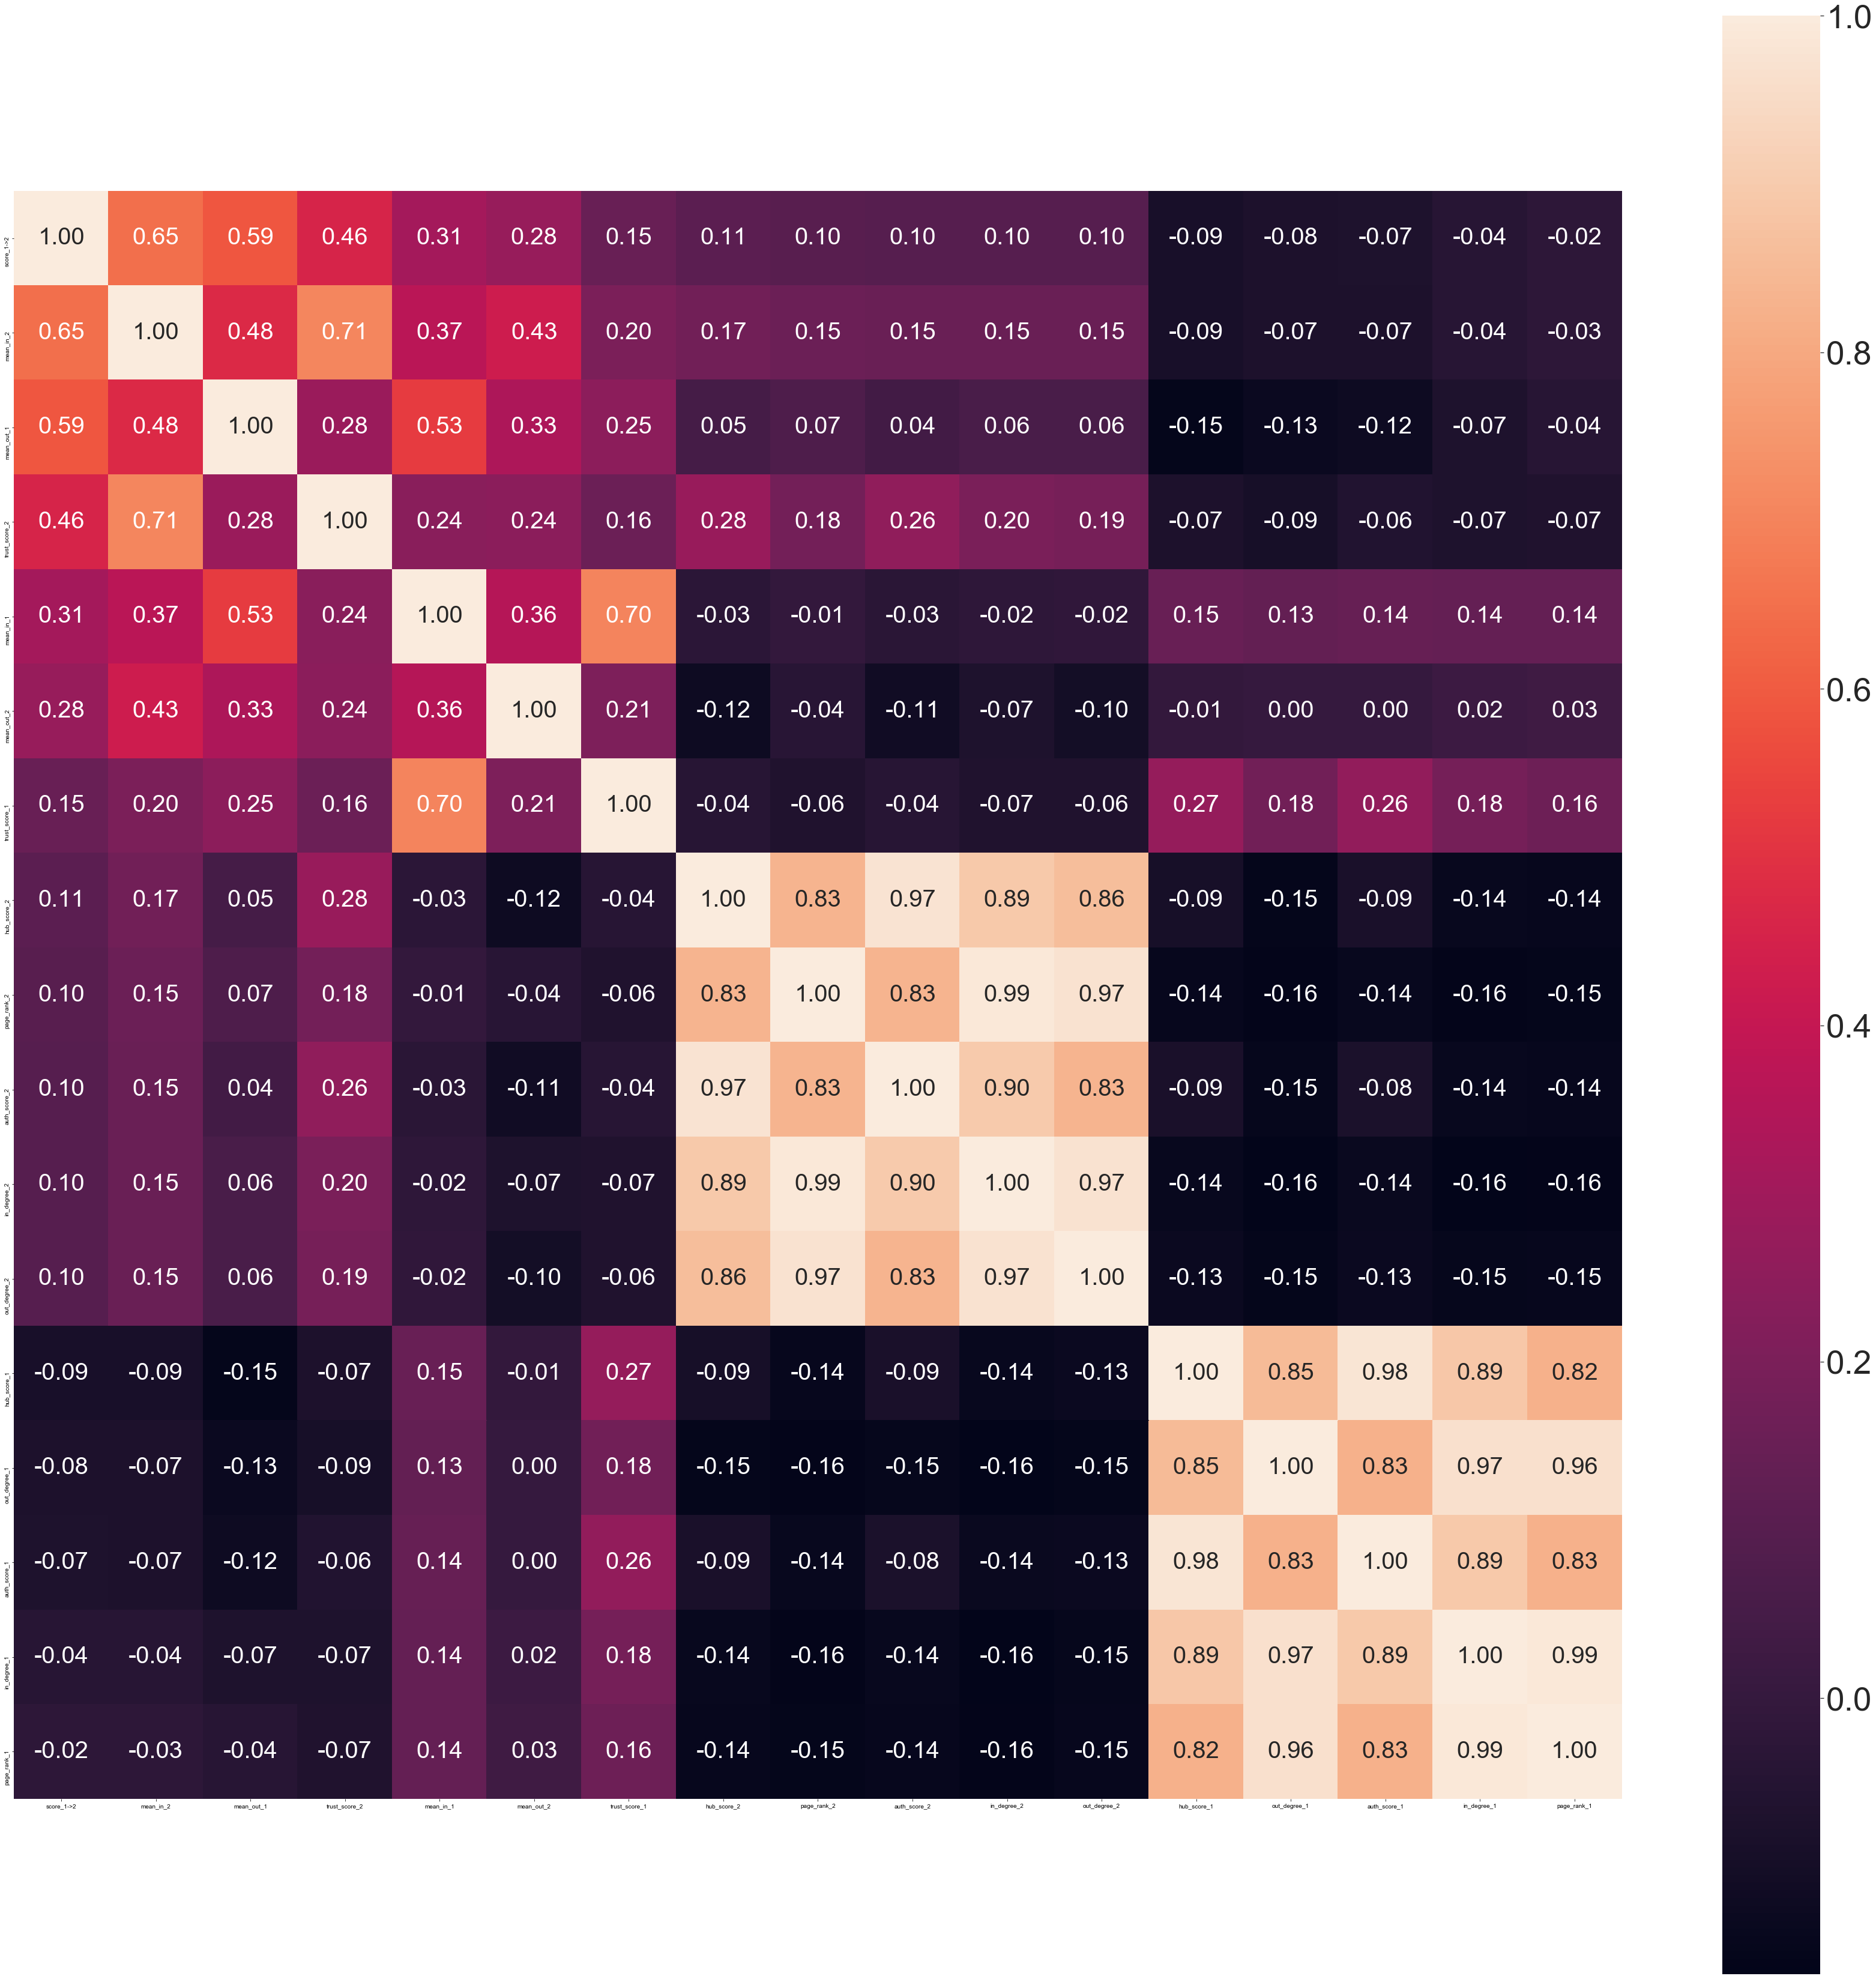

In [35]:
#correlation matrix
corrmat =abs(df.corr())

#saleprice correlation matrix
k = 17 #number of variables for heatmap
cols = corrmat.nlargest(k, 'score_1->2')['score_1->2'].index
f, ax = plt.subplots(figsize=(60,60))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 40}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [36]:
df.drop(['out_degree_1', 'out_degree_2', 'in_degree_1', 'in_degree_2',
       'page_rank_1', 'page_rank_2', 
       'auth_score_1', 'auth_score_2'], axis = 1,inplace = True)

In [37]:
df.head()

,hub_score_1,hub_score_2,mean_in_1,mean_in_2,mean_out_1,mean_out_2,trust_score_1,trust_score_2,score_1->2
0,0.001463,0.000776,1.386364,3.000000,2.425,3.177778,1.619318,3.567073,4
1,0.001463,0.000209,1.386364,2.333333,2.425,2.333333,1.619318,0.000000,2
2,0.001463,0.001507,1.386364,3.111111,2.425,2.777778,1.619318,3.217593,2
3,0.001463,0.003094,1.386364,2.842593,2.425,2.202586,1.619318,2.673611,5
4,0.001463,0.000147,1.386364,1.222222,2.425,1.166667,1.619318,1.388889,2


### Eliminating the trust score 

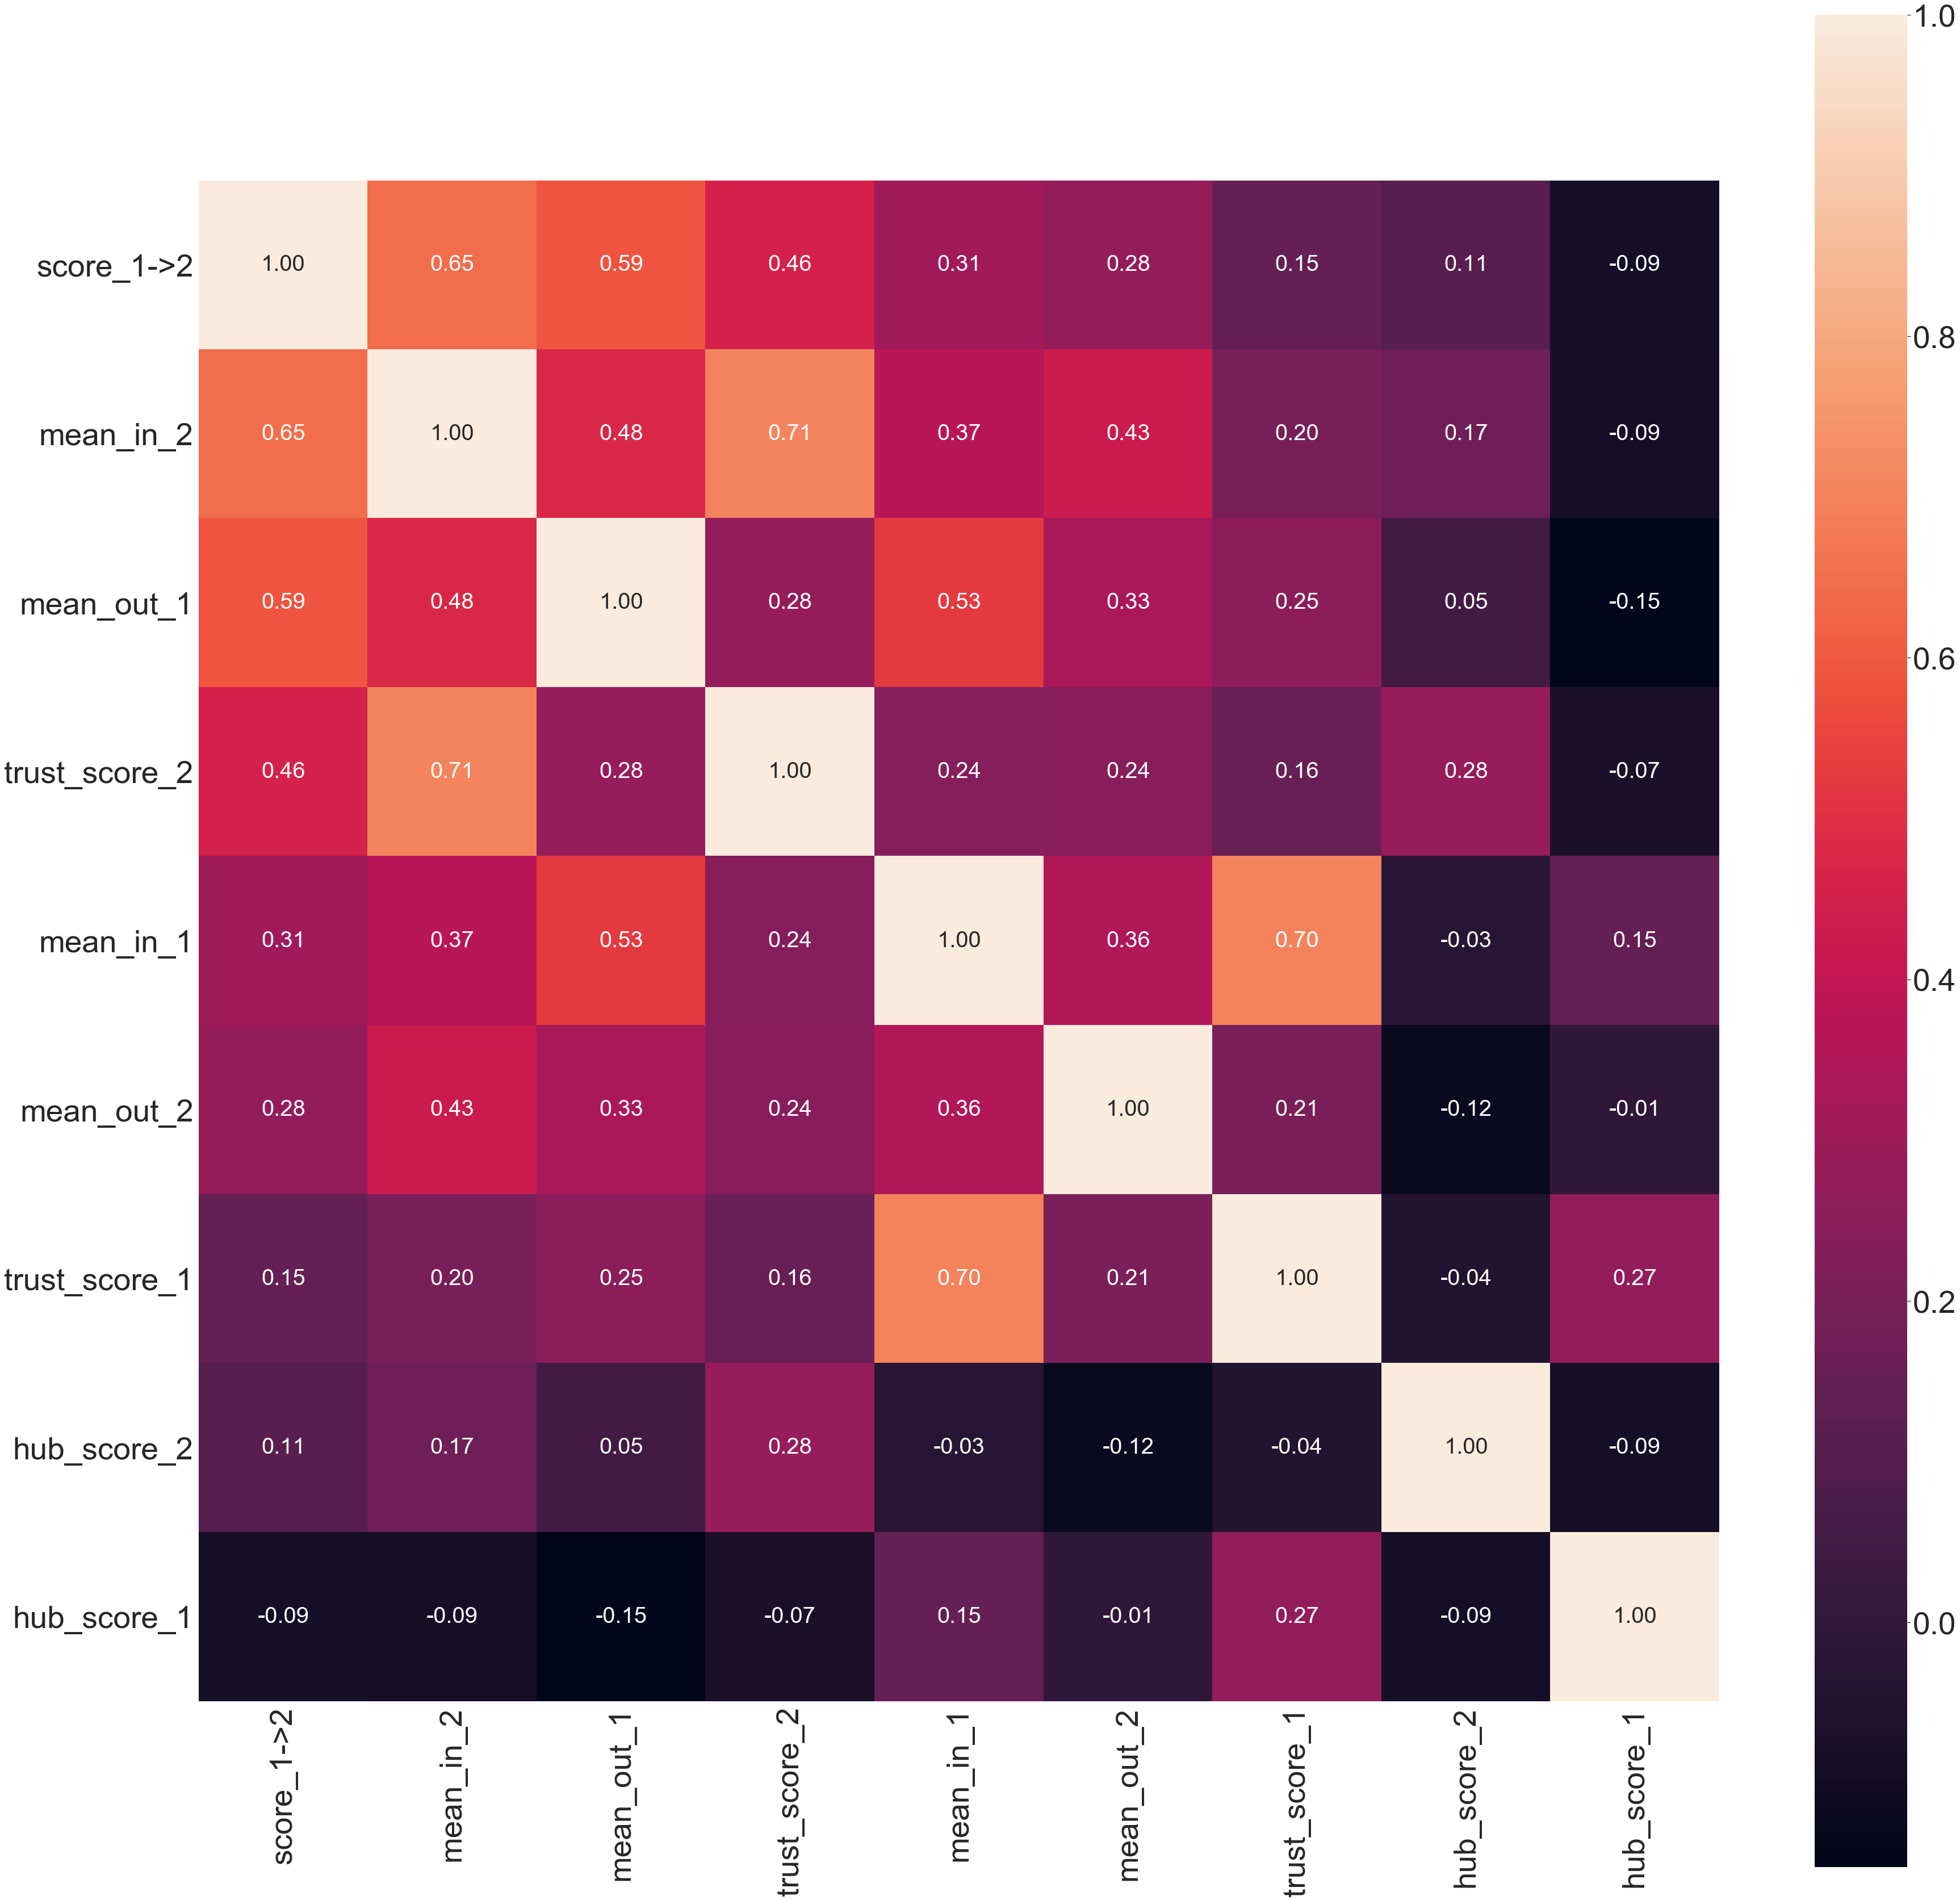

In [38]:
#correlation matrix
corrmat =abs(df.corr())

#saleprice correlation matrix
k = 9 #number of variables for heatmap
cols = corrmat.nlargest(k, 'score_1->2')['score_1->2'].index
f, ax = plt.subplots(figsize=(60,60))
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=5)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 40}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

# Predicting of the 1->2 score 

In [39]:
y=df['score_1->2']

In [40]:
len(y)

35592

In [41]:
df.shape

(35592, 9)

In [42]:
df.head()

,hub_score_1,hub_score_2,mean_in_1,mean_in_2,mean_out_1,mean_out_2,trust_score_1,trust_score_2,score_1->2
0,0.001463,0.000776,1.386364,3.000000,2.425,3.177778,1.619318,3.567073,4
1,0.001463,0.000209,1.386364,2.333333,2.425,2.333333,1.619318,0.000000,2
2,0.001463,0.001507,1.386364,3.111111,2.425,2.777778,1.619318,3.217593,2
3,0.001463,0.003094,1.386364,2.842593,2.425,2.202586,1.619318,2.673611,5
4,0.001463,0.000147,1.386364,1.222222,2.425,1.166667,1.619318,1.388889,2


In [61]:
train=df.iloc[:,6:8]

In [62]:
train.head()

,trust_score_1,trust_score_2
0,1.619318,3.567073
1,1.619318,0.000000
2,1.619318,3.217593
3,1.619318,2.673611
4,1.619318,1.388889


# Building the model 

In [63]:
from sklearn.model_selection import train_test_split

In [64]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.5, random_state=42)

## Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

## Analysis of the Model (Bitcoin OTC)

In [66]:
from sklearn.metrics import accuracy_score

In [67]:
str(int(round(accuracy_score(y_pred, y_test),2)*100))+' %'

'92 %'

In [68]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.30      0.42      1797
           1       0.93      0.99      0.96     15999

   micro avg       0.92      0.92      0.92     17796
   macro avg       0.82      0.64      0.69     17796
weighted avg       0.90      0.92      0.90     17796



## Model based on only two features and getting same or better results 

# Predicting of the binary : Good/Bad 1->2 score 

In [69]:
y=df['score_1->2']

In [70]:
l=[]
for elt in y : 
    if elt > 0 : 
        l.append(1)
    else : 
        l.append(0)
y=pd.DataFrame(l)

In [71]:
y;

# Building the model 

In [72]:
from sklearn.model_selection import train_test_split

In [73]:
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=0.5, random_state=42)

## Logistic Regression

In [74]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

## Analysis of the Model (Bitcoin OTC)

In [75]:
from sklearn.metrics import accuracy_score

In [76]:
str(int(round(accuracy_score(y_pred, y_test),2)*100))+' %'

'92 %'

In [77]:
from sklearn.metrics import classification_report

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.30      0.42      1797
           1       0.93      0.99      0.96     15999

   micro avg       0.92      0.92      0.92     17796
   macro avg       0.82      0.64      0.69     17796
weighted avg       0.90      0.92      0.90     17796

